In [1]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

## Environment

In [2]:
import numpy as np

import gym
from gym import spaces

import pygame

class RCMazeEnv(gym.Env):
    def __init__(self, maze_size_x=12, maze_size_y=12):
        self.maze_size_x = maze_size_x
        self.maze_size_y = maze_size_y
        self.maze = self.generate_maze()
        self.car_position = (1, 1)
        self.possible_actions = range(3)
        self.car_orientation = 'N'
        self.sensor_readings = {'front': 0, 'left': 0, 'right': 0}
        self.steps = 0
        self.previous_distance = 0
        self.goal = (10, 10)
        self.previous_steps = 0
        self.reset()

            
    def generate_maze(self):
        # For simplicity, create a static maze with walls
        # '1' represents a wall, and '0' represents an open path
        maze = np.zeros((self.maze_size_y, self.maze_size_x), dtype=int)
        # Add walls to the maze (this can be customized)

        layout = [
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
                [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1],
                [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
                [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1],
                [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
        
     
        maze = np.array(layout)

        return maze

    def reset(self):
        self.car_position = (1, 1)
        self.car_orientation = 'N'
        self.update_sensor_readings()
        self.steps = 0
        self.previous_distance = 0
        self.previous_steps = 0
        return self.get_state()

    def step(self, action):
        if action == 0:
            self.move_forward()
        elif action == 1:
            self.turn_left()
        elif action == 2:
            self.turn_right()
        self.update_sensor_readings()
        reward = self.compute_reward()
        self.steps += 1
        done = self.is_done()
        return self.get_state(), reward, done

    
    def move_forward(self):
        x, y = self.car_position
        if self.car_orientation == 'N' and y > 0 and self.maze[y - 1][x] != 1:
            self.car_position = (x, y - 1)
        elif self.car_orientation == 'S' and y < self.maze_size_y - 1 and self.maze[y + 1][x] != 1:
            self.car_position = (x, y + 1)
        elif self.car_orientation == 'E' and x < self.maze_size_x - 1 and self.maze[y][x + 1] != 1:
            self.car_position = (x + 1, y)
        elif self.car_orientation == 'W' and x > 0 and self.maze[y][x - 1] != 1:
            self.car_position = (x - 1, y)
        

    def turn_left(self):
        orientations = ['N', 'W', 'S', 'E']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def turn_right(self):
        orientations = ['N', 'E', 'S', 'W']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def update_sensor_readings(self):
        # Simple sensor implementation: counts steps to the nearest wall
        self.sensor_readings['front'] = self.distance_to_wall('front')
        self.sensor_readings['left'] = self.distance_to_wall('left')
        self.sensor_readings['right'] = self.distance_to_wall('right')

    def distance_to_wall(self, direction):
        x, y = self.car_position
        distance = 0
        max_distance = self.maze_size_x if direction in ['left', 'right'] else self.maze_size_y

        
        if direction == 'front':
            if self.car_orientation == 'N':
                while y - distance >= 0 and self.maze[y - distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'S':
                while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'E':
                while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                    distance += 1
            elif self.car_orientation == 'W':
                while x - distance >= 0 and self.maze[y][x - distance] != 1:
                    distance += 1
        elif direction == 'left':
            if self.car_orientation == 'N':
                while x - distance >= 0 and self.maze[y][x - distance] != 1:
                    distance += 1
            elif self.car_orientation == 'S':
                while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                    distance += 1
            elif self.car_orientation == 'E':
                while y - distance >= 0 and self.maze[y - distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'W':
                while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                    distance += 1
        elif direction == 'right':
            if self.car_orientation == 'N':
                while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                    distance += 1
            elif self.car_orientation == 'S':
                while x - distance >= 0 and self.maze[y][x - distance] != 1:
                    distance += 1
            elif self.car_orientation == 'E':
                while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'W':
                while y - distance >= 0 and self.maze[y - distance][x] != 1:
                    distance += 1
        
            # Normalize the measured distance
        normalized_distance = (max_distance - distance - 1) / (max_distance - 1)

        # Ensure the value is within the range [0, 1]
        normalized_distance = max(0, min(normalized_distance, 1))

        return normalized_distance
    
    def compute_reward(self):
        # # Initialize reward
        reward = 0

        # # Check for collision or out of bounds
        if any(self.sensor_readings[direction] == 0 for direction in ['front', 'left', 'right']):
            reward -= 20

        # # Check if goal is reached
        if self.car_position == self.goal:
            reward += 100
            # Additional penalty if it takes too many steps to reach the goal
            if self.steps > 750:
                reward -= 200
            return reward  # Return immediately as this is the terminal state

        # Calculate the Euclidean distance to the goal
        distance_to_goal = ((self.car_position[0] - self.goal[0]) ** 2 + (self.car_position[1] - self.goal[1]) ** 2) ** 0.5

        # Define a maximum reward when the car is at the goal
        max_reward_at_goal = 50

        # Reward based on proximity to the goal
        reward += max_reward_at_goal / (distance_to_goal + 1)  # Adding 1 to avoid division by zero

        # # Reward or penalize based on movement towards or away from the goal
        if distance_to_goal < self.previous_distance:
            reward += 50  # Positive reward for moving closer to the goal
        elif distance_to_goal > self.previous_distance:
            reward -= 25  # Negative reward for moving farther from the goal


        # Penalize for each step taken to encourage efficiency
        reward -= 2

        # # Update the previous_distance for the next step
        self.previous_distance = distance_to_goal
        return reward


        

    def is_done(self):
        # Define when the episode ends
        # ends when the car reaches the goal or it takes more than 3000 steps 
        return self.car_position == self.goal or self.steps > 3000
        
        
    def get_state(self):
        return (self.car_position, self.car_orientation, self.sensor_readings)

    # def render(self):
    #     rendered_maze = np.array(self.maze, dtype=str)
    #     x, y = self.car_position
    #     rendered_maze[y][x] = 'C'  # Representing the car
        
    #     #print array
    #     print(rendered_maze, '\n') 

    
    def init_pygame(self):
        # Initialize Pygame and set up the display
        pygame.init()
        self.cell_size = 40  # Size of each cell in pixels
        self.maze_size_x = 12  # Assuming the maze size_x is 12
        self.maze_size_y = 12  # Assuming the maze size_y is 12
        self.width = 600
        self.height = 600
        self.screen = pygame.display.set_mode((self.width, self.height))
        self.clock = pygame.time.Clock()

    def render(self):
        # Render the environment using Pygame
        for y in range(self.maze_size_y):
            for x in range(self.maze_size_x):
                rect = pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
                if (x, y) == self.goal:  # Goal position
                    color = (0, 255, 0)  # Green color for the goal
                elif self.maze[y][x] == 0:
                    color = (255, 255, 255)  # White color for empty space
                else:
                    color = (0, 0, 0)  # Black color for walls
                pygame.draw.rect(self.screen, color, rect)

        # Draw the car
        car_x, car_y = self.car_position
        car_rect = pygame.Rect(car_x * self.cell_size, car_y * self.cell_size, self.cell_size, self.cell_size)
        pygame.draw.rect(self.screen, (255, 0, 0), car_rect)  # Red color for the car

        pygame.display.flip()
        self.clock.tick(60)  # Limit the frame rate to 60 FPS


    def close_pygame(self):
        # Close the Pygame window
        pygame.quit()

## Q-agent

In [3]:
class QAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1, possible_actions=3, min_epsilon=0.01, epsilon_decay=0.99):
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.possible_actions = possible_actions
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        

    def state_to_tuple(self, state):
        if not isinstance(state[2], dict):
            #take state[2] and cast the state from this (1, 0, 0) to this {'front': 1, 'left': 0, 'right': 0}
            newState = {'front': state[2][0], 'left': state[2][1], 'right': state[2][2]}
            #create a new state with the [2] being the new dictionary
            state = (state[0], state[1], newState)
            
        # Convert the state dictionary to a hashable tuple
        position, orientation, sensor_readings = state
        sensor_readings_tuple = tuple(sensor_readings.values())
        return (position, orientation, sensor_readings_tuple)

    def get_q_value(self, state, action):
        state_tuple = self.state_to_tuple(state)
        return self.q_table.get((state_tuple, action), 0)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(range(self.possible_actions))
        else:
            state_tuple = self.state_to_tuple(state)
            q_values = [self.get_q_value(state_tuple, action) for action in range(self.possible_actions)]
            max_q = max(q_values)
            actions_with_max_q = [action for action, q in enumerate(q_values) if q == max_q]
            return random.choice(actions_with_max_q)

    def update_q_value(self, state, action, reward, next_state):
        state_tuple = self.state_to_tuple(state)
        next_state_tuple = self.state_to_tuple(next_state)
        max_q_next = max([self.get_q_value(next_state_tuple, next_action) for next_action in range(self.possible_actions)])
        current_q = self.get_q_value(state_tuple, action)
        new_q = current_q + self.alpha * (reward + self.gamma * max_q_next - current_q)
        self.q_table[(state_tuple, action)] = new_q

    def train(self, environment, num_episodes):
        reward_history = []
        for _ in range(num_episodes):
            state = environment.reset()
            done = False
            total_reward = 0
            while not done:
                # environment.render()
                action = self.choose_action(state)
                next_state, reward, done = environment.step(action)
                self.update_q_value(state, action, reward, next_state)
                total_reward += reward
                state = next_state

            # Add the total reward for this episode to the history
            reward_history.append(total_reward)

            # Decay epsilon, but not below the minimum value
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

            # Print episode summary
            print("Episode {} finished after {} timesteps".format(_ ,environment.steps))
            print("Total reward: {}, Epsilon: {:.3f}".format(total_reward, self.epsilon))

        return reward_history
            
    def test(self, env):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            env.render()
            action = self.choose_action(state)
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state
            

        print(f"Test Total Reward: {total_reward}")

# Example usage:
# env = RCMazeEnv()
# agent = QAgent()
# agent.train(env, 1000)


In [4]:
EPSILON = 0.9
ALPHA = 0.1
GAMMA = 0.6
DECAY = 0.999
MINEPSILON = 0.1
DECAY_RATE = 0.9999


env = RCMazeEnv()
agent = QAgent(alpha=ALPHA, gamma=GAMMA, epsilon=EPSILON, min_epsilon=MINEPSILON, epsilon_decay=DECAY_RATE)
# env.init_pygame()
rewards = agent.train(env, 4000)
# env.close_pygame()


Episode 0 finished after 377 timesteps
Total reward: 3611.910906924458, Epsilon: 0.900
Episode 1 finished after 290 timesteps
Total reward: 2670.070670213377, Epsilon: 0.900
Episode 2 finished after 2213 timesteps
Total reward: 14551.565386375196, Epsilon: 0.900
Episode 3 finished after 1160 timesteps
Total reward: 6720.595670143414, Epsilon: 0.900
Episode 4 finished after 2591 timesteps
Total reward: 13833.468144716137, Epsilon: 0.900
Episode 5 finished after 3001 timesteps
Total reward: 15020.246194388274, Epsilon: 0.899
Episode 6 finished after 1473 timesteps
Total reward: 8644.60585610632, Epsilon: 0.899
Episode 7 finished after 477 timesteps
Total reward: 3529.528257258595, Epsilon: 0.899
Episode 8 finished after 1423 timesteps
Total reward: 11837.981331829027, Epsilon: 0.899
Episode 9 finished after 2439 timesteps
Total reward: 13976.504609341604, Epsilon: 0.899
Episode 10 finished after 343 timesteps
Total reward: 3314.674301180361, Epsilon: 0.899
Episode 11 finished after 3001 

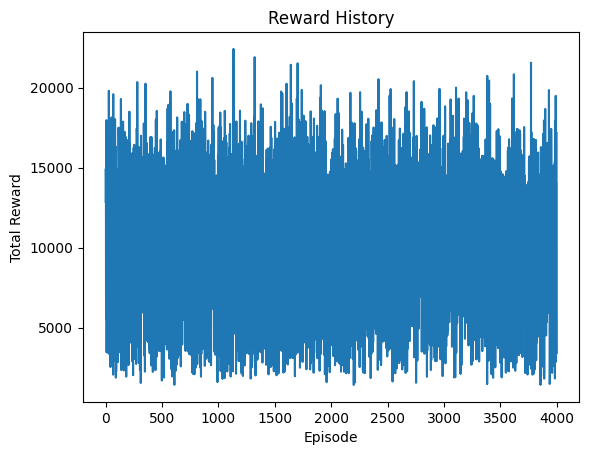

In [5]:
#plot rewards
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward History')
plt.show()

### test Q-agent

In [10]:
#test
env = RCMazeEnv()

env.init_pygame()

# Example of running the environment
agent.test(env)


env.close_pygame()

Test Total Reward: 11763.933972613984


In [8]:
env.close_pygame()

### conclusions

After testing it is clear that it is able to solve the enivronment. But not at all efficient, the car gets stuck multiple times and will take go backwards often. (This is probably caused by the over engineered reward function.)

## DQN

In [11]:
import gym
import random
import numpy as np   
import matplotlib.pyplot as plt
import collections

# Import Tensorflow libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

from IPython.display import HTML

from tqdm import tqdm

tqdm.pandas()

# disable eager execution (optimization)
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

2024-01-08 12:45:28.709201: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-08 12:45:28.725898: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 12:45:28.725920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 12:45:28.726416: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 12:45:28.729726: I tensorflow/core/platform/cpu_feature_guar

In [12]:
###### Tensorflow-GPU ########

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


2024-01-08 12:45:29.960574: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-08 12:45:29.976580: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-08 12:45:29.976681: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### environment

In [14]:
import numpy as np

import gym
from gym import spaces

import pygame

class RCMazeEnv(gym.Env):
    def __init__(self, maze_size_x=12, maze_size_y=12):
        self.maze_size_x = maze_size_x
        self.maze_size_y = maze_size_y
        self.maze = self.generate_maze()
        self.car_position = (1, 1)
        self.possible_actions = range(3)
        self.car_orientation = 'N'
        self.sensor_readings = {'front': 0, 'left': 0, 'right': 0}
        self.steps = 0
        self.previous_distance = 0
        self.goal = (10, 10)
        self.previous_steps = 0
        self.visited_positions = set()
        self.reset()

            
    def generate_maze(self):
        # For simplicity, create a static maze with walls
        # '1' represents a wall, and '0' represents an open path
        maze = np.zeros((self.maze_size_y, self.maze_size_x), dtype=int)
        # Add walls to the maze (this can be customized)

        
        layout = [
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
        
     
        maze = np.array(layout)

        return maze

    def reset(self):
        self.car_position = (1, 1)
        self.car_orientation = 'N'
        self.update_sensor_readings()
        self.steps = 0
        self.previous_distance = 0
        self.previous_steps = 0
        self.visited_positions.clear()  # Clear the visited positions
        self.visited_positions.add(self.car_position)
        return self.get_state()

    def step(self, action):
        if action == 0:
            self.move_forward()
        elif action == 1:
            self.turn_left()
        elif action == 2:
            self.turn_right()
        self.update_sensor_readings()
        self.visited_positions.add(self.car_position)
        reward = self.compute_reward()
        self.steps += 1
        done = self.is_done()
        return self.get_state(), reward, done

    
    def move_forward(self):
        x, y = self.car_position
        if self.car_orientation == 'N' and y > 0 and self.maze[y - 1][x] != 1:
            self.car_position = (x, y - 1)
        elif self.car_orientation == 'S' and y < self.maze_size_y - 1 and self.maze[y + 1][x] != 1:
            self.car_position = (x, y + 1)
        elif self.car_orientation == 'E' and x < self.maze_size_x - 1 and self.maze[y][x + 1] != 1:
            self.car_position = (x + 1, y)
        elif self.car_orientation == 'W' and x > 0 and self.maze[y][x - 1] != 1:
            self.car_position = (x - 1, y)
        

    def turn_left(self):
        orientations = ['N', 'W', 'S', 'E']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def turn_right(self):
        orientations = ['N', 'E', 'S', 'W']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def update_sensor_readings(self):
        # Simple sensor implementation: counts steps to the nearest wall
        self.sensor_readings['front'] = self.distance_to_wall('front')
        self.sensor_readings['left'] = self.distance_to_wall('left')
        self.sensor_readings['right'] = self.distance_to_wall('right')

    def distance_to_wall(self, direction):
        x, y = self.car_position
        distance = 0
        max_distance = self.maze_size_x if direction in ['left', 'right'] else self.maze_size_y

        
        if direction == 'front':
            if self.car_orientation == 'N':
                while y - distance >= 0 and self.maze[y - distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'S':
                while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'E':
                while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                    distance += 1
            elif self.car_orientation == 'W':
                while x - distance >= 0 and self.maze[y][x - distance] != 1:
                    distance += 1
        elif direction == 'left':
            if self.car_orientation == 'N':
                while x - distance >= 0 and self.maze[y][x - distance] != 1:
                    distance += 1
            elif self.car_orientation == 'S':
                while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                    distance += 1
            elif self.car_orientation == 'E':
                while y - distance >= 0 and self.maze[y - distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'W':
                while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                    distance += 1
        elif direction == 'right':
            if self.car_orientation == 'N':
                while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                    distance += 1
            elif self.car_orientation == 'S':
                while x - distance >= 0 and self.maze[y][x - distance] != 1:
                    distance += 1
            elif self.car_orientation == 'E':
                while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'W':
                while y - distance >= 0 and self.maze[y - distance][x] != 1:
                    distance += 1
        
            # Normalize the measured distance
        normalized_distance = (max_distance - distance - 1) / (max_distance - 1)

        # Ensure the value is within the range [0, 1]
        normalized_distance = max(0, min(normalized_distance, 1))

        return normalized_distance
    
    def compute_reward(self):
        # Initialize reward
        reward = 0

        # Check for collision or out of bounds
        if any(self.sensor_readings[direction] == 0 for direction in ['front', 'left', 'right']):
            reward -= 20

        # Check if goal is reached
        if self.car_position == self.goal:
            reward += 500
            # Additional penalty if it takes too many steps to reach the goal
            if self.steps > 1000:
                reward -= 200
            return reward  # Return immediately as this is the terminal state

        # Calculate the Euclidean distance to the goal
        distance_to_goal = ((self.car_position[0] - self.goal[0]) ** 2 + (self.car_position[1] - self.goal[1]) ** 2) ** 0.5

        # Define a maximum reward when the car is at the goal
        max_reward_at_goal = 50

        # Reward based on proximity to the goal
        reward += max_reward_at_goal / (distance_to_goal + 1)  # Adding 1 to avoid division by zero

        # # Reward or penalize based on movement towards or away from the goal
        if distance_to_goal < self.previous_distance:
            reward += 50  # Positive reward for moving closer to the goal
        elif distance_to_goal > self.previous_distance:
            reward -= 25  # Negative reward for moving farther from the goal

        if self.car_position in self.visited_positions:
            # Apply a penalty for revisiting the same position
            reward -= 10
            
        # Penalize for each step taken to encourage efficiency
        reward -= 2
        
        # Update the previous_distance for the next step
        self.previous_distance = distance_to_goal
        return reward


        

    def is_done(self):
        #is done if it reaches the goal or goes out of bounds or takes more than 3000 steps
        return self.car_position == self.goal or self.steps > 3000 or self.car_position[0] < 0 or self.car_position[1] < 0 or self.car_position[0] > 11 or self.car_position[1] > 11
        
        
        
    def get_state(self):
        car_position = [float(coord) for coord in self.car_position]
        sensor_readings = [float(value) for value in self.sensor_readings.values()]
        
        state = car_position + [self.car_orientation] + sensor_readings
        
        # cast state to this ['1.0' '1.0' 'N' '1.0' '1.0' '10.0']
        state = np.array(state, dtype=str)
        
        #get the orientation and convert do label encoding
        if state[2] == 'N':
            state[2] = 0
        elif state[2] == 'E':
            state[2] = 1
        elif state[2] == 'S':
            state[2] = 2
        elif state[2] == 'W':
            state[2] = 3
            
        state = np.array(state, dtype=float)
        
        return state

    
    def init_pygame(self):
        # Initialize Pygame and set up the display
        pygame.init()
        self.cell_size = 40  # Size of each cell in pixels
        self.maze_size_x = 12  # Assuming the maze size_x is 12
        self.maze_size_y = 12  # Assuming the maze size_y is 12
        self.width = 600
        self.height = 600
        self.screen = pygame.display.set_mode((self.width, self.height))
        self.clock = pygame.time.Clock()

    def render(self, framerate=60, delay=0):
        # Render the environment using Pygame
        for y in range(self.maze_size_y):
            for x in range(self.maze_size_x):
                rect = pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
                if (x, y) == self.goal:  # Goal position
                    color = (0, 255, 0)  # Green color for the goal
                elif self.maze[y][x] == 0:
                    color = (255, 255, 255)  # White color for empty space
                else:
                    color = (0, 0, 0)  # Black color for walls
                pygame.draw.rect(self.screen, color, rect)
        
        # Draw the car
        car_x, car_y = self.car_position
        car_rect = pygame.Rect(car_x * self.cell_size, car_y * self.cell_size, self.cell_size, self.cell_size)
        pygame.draw.rect(self.screen, (255, 0, 0), car_rect)  # Red color for the car
        pygame.time.delay(delay)
        pygame.display.flip()
        self.clock.tick(framerate)  # Limit the frame rate to 60 FPS


    def close_pygame(self):
        # Close the Pygame window
        pygame.quit()

In [15]:
from tensorflow.keras.optimizers.legacy import Adam
class DQAgent:
    def __init__(self, replayCapacity, inputShape, outputShape):
        ## Initialize replay memory
        self.capacity = replayCapacity
        self.memory = collections.deque(maxlen=self.capacity)
        self.populated = False
        ## Policiy model
        self.inputShape = inputShape
        self.outputShape = outputShape
        self.policy_model = self.buildNetwork()

        ## Target model
        self.target_model = self.buildNetwork()
        self.target_model.set_weights(self.policy_model.get_weights())

    def addToReplayMemory(self, step):
        self.step = step
        self.memory.append(self.step)

    def sampleFromReplayMemory(self, batchSize):
        self.batchSize = batchSize
        if self.batchSize > len(self.memory):
            self.populated = False
            return self.populated
        else:
            return random.sample(self.memory, self.batchSize)


    def buildNetwork(self):
        model = Sequential()
        model.add(Dense(32, input_shape=self.inputShape, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.outputShape, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['MeanSquaredError'])
        return model

    def policy_network_fit(self,batch, batchSize):
        self.batchSize = batchSize
        self.batch = batch


    def policy_network_predict(self, state):
        self.state = state
        self.qPolicy = self.policy_model.predict(self.state)
        return self.qPolicy

    def target_network_predict(self, state):
        self.state = state
        self.qTarget = self.target_model.predict(self.state)
        return self.qTarget

    def update_target_network(self):
        self.target_model.set_weights(self.policy_model.get_weights())

In [16]:
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

# Model parameters
REPLAY_MEMORY_CAPACITY = 20000
# MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
POSSIBLE_ACTIONS = env.possible_actions

# state = state[0]
# create DQN agent
agent = DQAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, inputShape=state.shape, outputShape=len(POSSIBLE_ACTIONS))


# reset the parameters
DISCOUNT = 0.90
BATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_INTERVAL = 500
EPSILON = 0.99 # Exploration percentage
MIN_EPSILON = 0.01
DECAY = 0.9999
EPISODE_AMOUNT = 170

# Fill the replay memory with the first batch of samples
updateCounter = 0
rewardHistory = []
epsilonHistory = []

np.set_printoptions(precision=3, suppress=True)

for episode in range(EPISODE_AMOUNT):
    episodeReward = 0
    stepCounter = 0  # count the number of successful steps within the episode

    state = env.reset()
    done = False
    epsilonHistory.append(EPSILON)

    while not done:
        env.render(delay=0, framerate=240)

        if random.random() <= EPSILON:
            action = random.sample(POSSIBLE_ACTIONS, 1)[0]
        else:
            qValues = agent.policy_network_predict(state.reshape(1,-1))
            action = np.argmax(qValues[0])

        newState, reward, done = env.step(action)

        stepCounter +=1

        # store step in replay memory
        step = (state, action, reward, newState, done)
        agent.addToReplayMemory(step)
        state = newState
        episodeReward += reward
        # When enough steps in replay memory -> train policy network
        if len(agent.memory) >= (BATCH_SIZE):
            EPSILON = DECAY * EPSILON
            if EPSILON < MIN_EPSILON:
                EPSILON = MIN_EPSILON
            # sample minibatch from replay memory
            
            miniBatch = agent.sampleFromReplayMemory(BATCH_SIZE)
            miniBatch_states = np.asarray(list(zip(*miniBatch))[0],dtype=float)
            miniBatch_actions = np.asarray(list(zip(*miniBatch))[1], dtype = int)
            miniBatch_rewards = np.asarray(list(zip(*miniBatch))[2], dtype = float)
            miniBatch_next_state = np.asarray(list(zip(*miniBatch))[3],dtype=float)
            miniBatch_done = np.asarray(list(zip(*miniBatch))[4],dtype=bool)
            
            # current state q values1tch_states)
            y = agent.policy_network_predict(miniBatch_states)

            next_state_q_values = agent.target_network_predict(miniBatch_next_state)
            max_q_next_state = np.max(next_state_q_values,axis=1)

            for i in range(BATCH_SIZE):
                if miniBatch_done[i]:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i]
                else:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i] + DISCOUNT *  max_q_next_state[i]

            agent.policy_model.fit(miniBatch_states, y, batch_size=2048, verbose = 0)
            
            #todo: add early stopping
            
        else:
            continue
        if updateCounter == UPDATE_TARGET_INTERVAL:
            agent.update_target_network()
            updateCounter = 0
        updateCounter += 1
    print('episodeReward for episode ', episode, '= ', episodeReward, 'with epsilon = ', EPSILON)
    env.render(delay=0, framerate=240)
    rewardHistory.append(episodeReward)
env.close_pygame()
env.close()

2024-01-08 12:45:50.173062: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-08 12:45:50.173164: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-08 12:45:50.173207: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

episodeReward for episode  0 =  -2485.9072786282477 with epsilon =  0.8807722660973293
episodeReward for episode  1 =  -202.20886105172076 with epsilon =  0.845981153866556
episodeReward for episode  2 =  336.92126257727546 with epsilon =  0.8088349164463933
episodeReward for episode  3 =  1269.235143957906 with epsilon =  0.7893372089993652
episodeReward for episode  4 =  -7881.940058086577 with epsilon =  0.5846881401775113
episodeReward for episode  5 =  -9628.990299366791 with epsilon =  0.44955826643125446


KeyboardInterrupt: 

In [17]:
env.close_pygame()

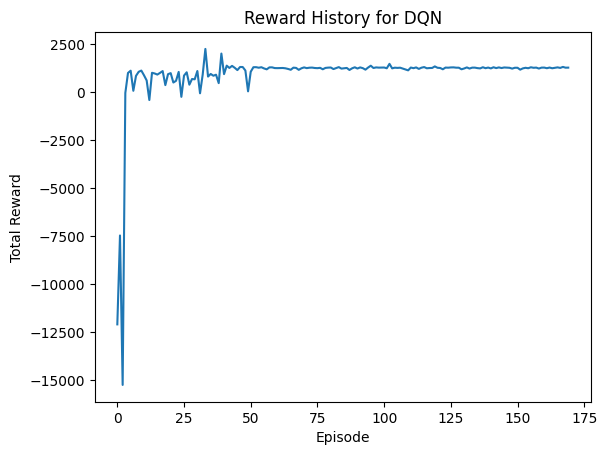

In [38]:
#plot rewards
plt.plot(rewardHistory)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward History for DQN')
plt.show()



In [26]:
#save model
agent.policy_model.save('./models/DQN_RCmaze_v2.h5')

/home/lucasdriessens/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### test

In [19]:
# try it out
# load model
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

REPLAY_MEMORY_CAPACITY = 20000
POSSIBLE_ACTIONS = env.possible_actions

# create DQN agent
test_agent = DQAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, inputShape=state.shape, outputShape=len(POSSIBLE_ACTIONS))


from keras.models import load_model
test_agent.policy_model = load_model('./models/DQN_RCmaze_v2.h5')


done = False

rewards = []

while not done:
    env.render(delay=100, framerate=60)
    xd = state
    qValues = test_agent.policy_network_predict(np.array([state]))
    action = np.argmax(qValues[0])
    state, reward, done = env.step(action)
    rewards.append(reward)
    
    env.render()
    if done:
        print('done in ', len(rewards), 'steps')
        break
env.close()
print(sum(rewards))
env.close_pygame()


2024-01-08 12:47:26.144459: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_29/kernel/Assign' id:1776 op device:{requested: '', assigned: ''} def:{{{node dense_29/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_29/kernel, dense_29/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-08 12:47:26.260517: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_52_1/bias/Assign' id:1951 op device:{requested: '', assigned: ''} def:{{{node dense_52_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_52_1/bias, dense_52_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, an

done in  34 steps
1296.992428778307


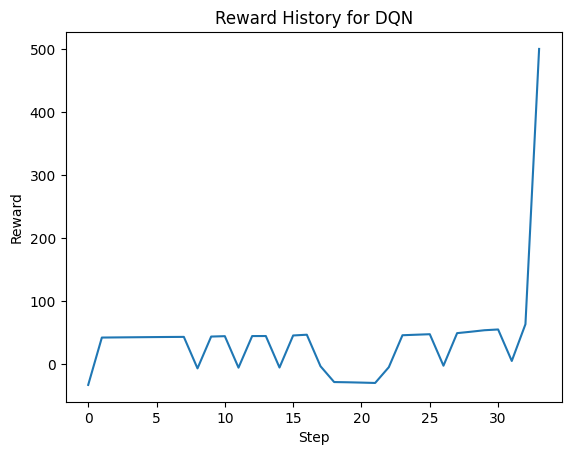

In [43]:
#plot rewards and distance to goal
plt.plot(rewards)
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Reward History for DQN')
plt.show()



### conclusions

The DQN is able to solve the environment in 34 steps, which is a great improvement over the Q-agent. The car now goes straight to the goal, so this is something I can work with.

# 3d env

In [ ]:
import numpy as np

import gym
from gym import spaces

from OpenGL.GL import *
from OpenGL.GLUT import *
from OpenGL.GLU import *

import pygame

import random
import matplotlib.pyplot as plt
import collections



In [ ]:
class RCMazeEnv(gym.Env):
   def __init__(self, maze_size_x=12, maze_size_y=12):
      self.maze_size_x = maze_size_x
      self.maze_size_y = maze_size_y
      self.maze = self.generate_maze()
      self.car_position = (1, 1)
      self.possible_actions = range(3)
      self.car_orientation = 'N'
      self.sensor_readings = {'front': 0, 'left': 0, 'right': 0}
      self.steps = 0
      self.previous_distance = 0
      self.goal = (10, 10)
      self.previous_steps = 0
      self.visited_positions = set()
      self.reset()

         
   def generate_maze(self):
      # For simplicity, create a static maze with walls
      # '1' represents a wall, and '0' represents an open path
      maze = np.zeros((self.maze_size_y, self.maze_size_x), dtype=int)
      # Add walls to the maze (this can be customized)

      
      layout = [
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
         [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
         [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
         [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
         [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
         [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
         [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
      
   
      maze = np.array(layout)

      return maze

   def reset(self):
      self.car_position = (1, 1)
      self.car_orientation = 'N'
      self.update_sensor_readings()
      self.steps = 0
      self.previous_distance = 0
      self.previous_steps = 0
      self.visited_positions.clear()  # Clear the visited positions
      self.visited_positions.add(self.car_position)
      return self.get_state()

   def step(self, action):
      if action == 0:
         self.move_forward()
      elif action == 1:
         self.turn_left()
      elif action == 2:
         self.turn_right()
      self.update_sensor_readings()
      self.visited_positions.add(self.car_position)
      reward = self.compute_reward()
      self.steps += 1
      done = self.is_done()
      return self.get_state(), reward, done

   
   def move_forward(self):
      x, y = self.car_position
      if self.car_orientation == 'N' and y > 0 and self.maze[y - 1][x] != 1:
         self.car_position = (x, y - 1)
      elif self.car_orientation == 'S' and y < self.maze_size_y - 1 and self.maze[y + 1][x] != 1:
         self.car_position = (x, y + 1)
      elif self.car_orientation == 'E' and x < self.maze_size_x - 1 and self.maze[y][x + 1] != 1:
         self.car_position = (x + 1, y)
      elif self.car_orientation == 'W' and x > 0 and self.maze[y][x - 1] != 1:
         self.car_position = (x - 1, y)
      

   def turn_left(self):
      orientations = ['N', 'W', 'S', 'E']
      idx = orientations.index(self.car_orientation)
      self.car_orientation = orientations[(idx + 1) % 4]

   def turn_right(self):
      orientations = ['N', 'E', 'S', 'W']
      idx = orientations.index(self.car_orientation)
      self.car_orientation = orientations[(idx + 1) % 4]

   def update_sensor_readings(self):
      # Simple sensor implementation: counts steps to the nearest wall
      self.sensor_readings['front'] = self.distance_to_wall('front')
      self.sensor_readings['left'] = self.distance_to_wall('left')
      self.sensor_readings['right'] = self.distance_to_wall('right')

   def distance_to_wall(self, direction):
      x, y = self.car_position
      distance = 0
      max_distance = self.maze_size_x if direction in ['left', 'right'] else self.maze_size_y
      
      if direction == 'front':
         if self.car_orientation == 'N':
               while y - distance >= 0 and self.maze[y - distance][x] != 1:
                  distance += 1
         elif self.car_orientation == 'S':
               while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                  distance += 1
         elif self.car_orientation == 'E':
               while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:     
                  distance += 1
         elif self.car_orientation == 'W':
               while x - distance >= 0 and self.maze[y][x - distance] != 1:
                  distance += 1
      elif direction == 'left':
         if self.car_orientation == 'N':
               while x - distance >= 0 and self.maze[y][x - distance] != 1:
                  distance += 1
         elif self.car_orientation == 'S':
               while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                  distance += 1
         elif self.car_orientation == 'E':
               while y - distance >= 0 and self.maze[y - distance][x] != 1:
                  distance += 1
         elif self.car_orientation == 'W':
               while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                  distance += 1
      elif direction == 'right':
         if self.car_orientation == 'N':
               while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                  distance += 1
         elif self.car_orientation == 'S':
               while x - distance >= 0 and self.maze[y][x - distance] != 1:
                  distance += 1
         elif self.car_orientation == 'E':
               while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                  distance += 1
         elif self.car_orientation == 'W':
               while y - distance >= 0 and self.maze[y - distance][x] != 1:
                  distance += 1
      
         # Normalize the measured distance
      normalized_distance = (max_distance - distance - 1) / (max_distance - 1)

      # Ensure the value is within the range [0, 1]
      normalized_distance = max(0, min(normalized_distance, 1))

      return normalized_distance
   
   def compute_reward(self):
      # Initialize reward
      reward = 0

      # Check for collision or out of bounds
      if any(self.sensor_readings[direction] == 0 for direction in ['front', 'left', 'right']):
         reward -= 20

      # Check if goal is reached
      if self.car_position == self.goal:
         reward += 500
         # Additional penalty if it takes too many steps to reach the goal
         if self.steps > 1000:
               reward -= 200
         return reward  # Return immediately as this is the terminal state

      # Calculate the Euclidean distance to the goal
      distance_to_goal = ((self.car_position[0] - self.goal[0]) ** 2 + (self.car_position[1] - self.goal[1]) ** 2) ** 0.5

      # Define a maximum reward when the car is at the goal
      max_reward_at_goal = 50

      # Reward based on proximity to the goal
      reward += max_reward_at_goal / (distance_to_goal + 1)  # Adding 1 to avoid division by zero

      # # Reward or penalize based on movement towards or away from the goal
      if distance_to_goal < self.previous_distance:
         reward += 50  # Positive reward for moving closer to the goal
      elif distance_to_goal > self.previous_distance:
         reward -= 25  # Negative reward for moving farther from the goal

      if self.car_position in self.visited_positions:
         # Apply a penalty for revisiting the same position
         reward -= 10
         
      # Penalize for each step taken to encourage efficiency
      reward -= 2
      
      # Update the previous_distance for the next step
      self.previous_distance = distance_to_goal
      return reward

   def is_done(self):
      #is done if it reaches the goal or goes out of bounds or takes more than 3000 steps
      return self.car_position == self.goal or self.steps > 3000 or self.car_position[0] < 0 or self.car_position[1] < 0 or self.car_position[0] > 11 or self.car_position[1] > 11
      
   def get_state(self):
      car_position = [float(coord) for coord in self.car_position]
      sensor_readings = [float(value) for value in self.sensor_readings.values()]
      
      state = car_position + [self.car_orientation] + sensor_readings
      
      # cast state to this ['1.0' '1.0' 'N' '1.0' '1.0' '10.0']
      state = np.array(state, dtype=str)
      
      #get the orientation and convert do label encoding
      if state[2] == 'N':
         state[2] = 0
      elif state[2] == 'E':
         state[2] = 1
      elif state[2] == 'S':
         state[2] = 2
      elif state[2] == 'W':
         state[2] = 3
         
      state = np.array(state, dtype=float)
      
      return state

   def init_opengl(self):
      # Initialize OpenGL context
      glutInit()
      glutInitDisplayMode(GLUT_RGBA | GLUT_DOUBLE | GLUT_DEPTH)
      glutInitWindowSize(1200, 1200)
      glutCreateWindow("RC Maze Environment")

      # Set up OpenGL environment
      glEnable(GL_DEPTH_TEST)
      glClearColor(0.0, 0.0, 0.0, 0.0)  # Clear to a grey color

      # Set up lighting (optional)
      glEnable(GL_LIGHTING)
      glEnable(GL_LIGHT0)
      glLightfv(GL_LIGHT0, GL_POSITION, [0, 10, 10, 1])
      glLightfv(GL_LIGHT0, GL_AMBIENT, [0.1, 0.1, 0.1, 1])
      glLightfv(GL_LIGHT0, GL_DIFFUSE, [1, 1, 1, 1])
      
      glColorMaterial(GL_FRONT_AND_BACK, GL_AMBIENT_AND_DIFFUSE)
      glEnable(GL_COLOR_MATERIAL)

      # Set up camera (you may want to make this adjustable)
      gluLookAt(self.maze_size_x / 2, self.maze_size_y / 2, 10,  # Camera position (above the center of the maze)
          self.maze_size_x / 2, self.maze_size_y / 2, 0,  # Look at point (center of the maze)
          0, 1, 0)  # Up vector
      
      glMatrixMode(GL_PROJECTION)
      glLoadIdentity()
      gluPerspective(90, 1, 0.1, 100)  # Adjust field of view angle, aspect ratio, near and far planes
      glMatrixMode(GL_MODELVIEW)
      glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
      
      
      
      
        # Set the rendering function
      glutDisplayFunc(self.render)
      
   def run_opengl(self):
        # Set up the rendering context and callbacks
        # but do NOT call glutMainLoop()
        glutDisplayFunc(self.render)
        glutIdleFunc(self.render)  # Update rendering in idle time

   def render(self):
      # Clear buffers
      glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
      camera_distance = 0.5 # Distance from the camera to the car
      camera_height = 1.5  # Height of the camera above the car
      
      # Assuming self.car_orientation is 'N' and you want to be behind the car (to the 'S')
      if self.car_orientation == 'N':  # Car is facing North
         camera_x = self.car_position[0]
         camera_y = (self.maze_size_y - self.car_position[1] - 1) - camera_distance  # Move camera to South
         camera_z = camera_height
      elif self.car_orientation == 'S':  # Car is facing South
         camera_x = self.car_position[0]
         camera_y = (self.maze_size_y - self.car_position[1] - 1) + camera_distance  # Move camera to North
         camera_z = camera_height
      elif self.car_orientation == 'E':  # Car is facing East
         camera_x = self.car_position[0] - camera_distance  # Move camera to West
         camera_y = self.maze_size_y - self.car_position[1] - 1
         camera_z = camera_height
      elif self.car_orientation == 'W':  # Car is facing West
         camera_x = self.car_position[0] + camera_distance  # Move camera to East
         camera_y = self.maze_size_y - self.car_position[1] - 1
         camera_z = camera_height

      # The point where the camera should be pointed: the car's position
      look_at_x = self.car_position[0]
      look_at_y = self.maze_size_y - self.car_position[1] - 1
      look_at_z = 1  # Assuming the car is at ground level (z=0)

      # Set up the camera
      glMatrixMode(GL_MODELVIEW)
      glLoadIdentity()
      gluLookAt(camera_x, camera_y, camera_z,  # Camera position (x, y, z)
               look_at_x, look_at_y, look_at_z,  # Look at position (x, y, z)
               0, 0, 2)  # Up vector (x, y, z), assuming Z is up

      # Render the maze
      for y in range(self.maze_size_y):
         for x in range(self.maze_size_x):
               if self.maze[y][x] == 1:
                  self.draw_cube(x, y, color=(0.5, 0.5, 0.5))
               elif (x, y) == self.goal:
                  #set color to green
                  self.draw_cube(x, y, color=(0.0, 1.0, 0.0))
                  
      # Render the car's sensor readings
      car_x, car_y = self.car_position
      #set sensor_color_directon with front being light blue, left being yellow and right being green
      sensor_colors = {'front': (0.0, 1.0, 1.0), 'left': (1.0, 1.0, 0.0), 'right': (0.0, 1.0, 0.0)}
      
      # Render the sensors
      for sensor in ['front', 'left', 'right']:
         self.draw_sensor_line(car_x, car_y, self.sensor_readings[sensor], 
                                 sensor_colors[sensor], sensor)
         
      # Draw the car
      car_x, car_y = self.car_position
      self.draw_car(car_x, car_y, color=(1.0, 0.0, 0.0))
      
      # Swap buffers
      glutSwapBuffers()
      

   def draw_cube(self, x, y, color):
      # Set the color
      glColor3fv(color)

      # Draw a cube at position (x, y), flipping y coordinate
      glPushMatrix()
      glTranslate(x, self.maze_size_y - y - 1, 0)  # Adjust for vertical flipping
      glScalef(2, 2, 5)  # Adjust the size of your cube
      glutSolidCube(0.5)  # Adjust the size if needed
      glPopMatrix()
      
   def get_sensor_rotation_angle(self, sensor_orientation):
      print('direction: ', self.car_orientation)
      # Rotation logic based on car's orientation and sensor's relative position
      rotation_mapping = {
         'N': {'front': 0, 'left': 90, 'right': -90},
         'S': {'front': -90, 'left': 0, 'right': 180},
         'E': {'front': 0, 'left': 90, 'right': -90},
         'W': {'front': 180, 'left': -90, 'right': 90}
      }


      # Calculate total rotation angle
      return rotation_mapping[self.car_orientation][sensor_orientation]

   def draw_sensor_line(self, car_x, car_y, distance, color, sensor_orientation):
      close_threshold = 0.5
      glColor3fv((1.0, 0.0, 0.0) if distance <= close_threshold else color)

      # Calculate rotation based on car's and sensor's orientation
      rotation_angle = self.get_sensor_rotation_angle(sensor_orientation)

      glPushMatrix()
      glTranslate(car_x, self.maze_size_y - car_y - 1, 0.5)  # Adjust for vertical flipping
      glRotatef(rotation_angle, 0, 0, 1)
      glRotatef(90, 0, 1, 0)

      # Draw sensor line
      distance = min(distance, 0.5)  # Cap distance
      glutSolidCylinder(0.05, distance, 5, 5)

      glPopMatrix()

   def draw_car(self, x, y, color):
      # Set the color
      glColor3fv(color)

      # Draw a cube at position (x, y), flipping y coordinate
      glPushMatrix()
      glTranslate(x, self.maze_size_y - y - 1, 0)  # Adjust for vertical flipping
      glScalef(1, 1, 1)  # Adjust the size of your cube
      glutSolidCube(0.5)  # Adjust the size if needed
      glPopMatrix()

   def close_opengl(self):
      # Close the OpenGL context
      glutLeaveMainLoop()


In [ ]:
class DQNAgent:
    def __init__(self, replayCapacity, inputShape, outputShape):
        ## Initialize replay memory
        self.capacity = replayCapacity
        self.memory = collections.deque(maxlen=self.capacity)
        self.populated = False
        ## Policiy model
        self.inputShape = inputShape
        self.outputShape = outputShape
        self.policy_model = self.buildNetwork()

        ## Target model
        self.target_model = self.buildNetwork()
        self.target_model.set_weights(self.policy_model.get_weights())

    def addToReplayMemory(self, step):
        self.step = step
        self.memory.append(self.step)

    def sampleFromReplayMemory(self, batchSize):
        self.batchSize = batchSize
        if self.batchSize > len(self.memory):
            self.populated = False
            return self.populated
        else:
            return random.sample(self.memory, self.batchSize)


    def buildNetwork(self):
        model = Sequential()
        model.add(Dense(32, input_shape=self.inputShape, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.outputShape, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['MeanSquaredError'])
        return model

    def policy_network_fit(self,batch, batchSize):
        self.batchSize = batchSize
        self.batch = batch


    def policy_network_predict(self, state):
        self.state = state
        self.qPolicy = self.policy_model.predict(self.state)
        return self.qPolicy

    def target_network_predict(self, state):
        self.state = state
        self.qTarget = self.target_model.predict(self.state)
        return self.qTarget

    def update_target_network(self):
        self.target_model.set_weights(self.policy_model.get_weights()) 


In [ ]:
import time
env = RCMazeEnv()
state = env.reset()

env.init_opengl()
env.run_opengl()

REPLAY_MEMORY_CAPACITY = 20000
POSSIBLE_ACTIONS = env.possible_actions

# create DQN agent
test_agent = DQNAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, inputShape=state.shape, outputShape=len(POSSIBLE_ACTIONS))


from keras.models import load_model
test_agent.policy_model = load_model('./models/DQN_RCmaze_v2.h5')

done = False
rewards = []

desired_fps = 5.0
frame_duration = 1.0 / desired_fps

last_time = time.time()
done = False


while not done:
   current_time = time.time()
   elapsed = current_time - last_time
   if elapsed >= frame_duration:
      
      glutMainLoopEvent()
      qValues = test_agent.policy_network_predict(np.array([state]))
      action = np.argmax(qValues[0])
      state, reward, done = env.step(action)
      rewards.append(reward)
      env.render()
      
      last_time = current_time
      
      if done:
         print('done in ', len(rewards), 'steps')
         break
# env.close()
print(sum(rewards))